In [1]:
import pandas as pd
import re
from scipy.signal import correlate
import numpy as np
import sys
sys.path.append(r'C:\Users\clima\Desktop\Aptamers\src')
import time
from sklearn.manifold import TSNE
from sklearn.cluster import OPTICS
import os
from APTamers import  Aptamer_Fold
from tqdm import tqdm
from utils import check_char, check_if_string, check_structure, check_empty_or_short, find_substrings,  attach_stems
import pandas as pd
import forgi.visual.mplotlib as fvm
import forgi
from forgi.graph.bulge_graph import BulgeGraph
import matplotlib.pyplot as plt
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.cluster import SpectralClustering


In [27]:
def compute_descriptor(input_string):
    descriptor = []
    sum = 0
    for  char in input_string:
        if char == '(':
            sum +=1
            descriptor.append(sum)
        elif char == ')':
            sum -=1 
            descriptor.append(sum)
        elif char == '.':
            descriptor.append(sum)      
    return descriptor


def substructure_ID(string):
    w= compute_descriptor(string)
    
    dct = {'hairpins' : [],
    'multi-branches' : [],
    'stacks' : [],
    'left_bulges' : [],
    'right_bulges' : [],
    'inner_loops' : [] }
    
    stacks = []
    for count, s in enumerate(string):
        if s == '(':
            stacks.append(count)
            
        elif s == ')':
            i = stacks.pop(-1)
            j = count
            
            if w[i]==w[i+1]-1 and w[j]==w[j-1]-1:
                dct['stacks'].append((i,j))
                
            else:
                l = w[j]
                L = np.where(w[i:j]== l+1)[0]
                T =len(L)/2
                stat = [i] + list(L) + [j]
                if T == 0:
                    dct['hairpins'].append((i,j))
                elif T == 1:
                    if w[i]==w[i+1]-1 and w[j]!=w[j-1]-1: #right buldge
                        dct['left_buldges'].append([(stat[k], stat[k-1]) for k in range(len(stat)/2-1)])
                        #dct['right_buldges'].append((i,j))
                    elif w[i]!=w[i+1]-1 and w[j]==w[j-1]-1: #left buldge
                        dct['left_buldges'].append([(stat[k], stat[k-1]) for k in range(len(stat)/2-1)])
                        #dct['left_buldges'].append((i,j))
                    else:
                        dct['inner_loops'].append([(stat[k], stat[k-1]) for k in range(len(stat)/2-1)])
                        #dct['inner_loops'].append((i,j))
                elif T > 1:
                    dct['multi-branches'].append([(stat[k], stat[k-1]) for k in range(len(stat)/2-1)])
                    
                
            
            
            
        
        

In [26]:
len(np.where(w[3:8]== 3)[0])
w[3:8]

array([3, 3, 3, 3, 2])

In [19]:
import numpy as np
w = np.array([0,1,2,3,3,3,3,2,2,2,2,1,0])
l = 2
print( [100] + list(np.where(w[:]== 0)[0]) + [111])


[100, 0, 12, 111]


In [3]:
df = pd.read_csv(r'C:\Users\clima\Desktop\Aptamers\data\preprocessed _files\merged_all.csv')
print('Numeber sequences after merge:',len(df))
df = df.drop_duplicates(subset='Sequence')
print('Numeber of unique sequences after merge:',len(df))
df.head()

df['Descriptor'] = df['Structure_graph_match'].apply(lambda x: compute_descriptor(x) )
df['Descriptor'] = df['Descriptor'] .apply(lambda x: np.array(x[8:-8]))
percentile_95 = np.percentile(df['Descriptor'].apply(len), 95) 
percentile_3 = np.percentile(df['Descriptor'].apply(len), 5)
# Filter DataFrame to remove rows with list lengths outside the 95th percentile
df = df[df['Descriptor'].apply(len).between(0, np.ceil(percentile_95))]
df = df[df['Descriptor'].apply(len) > np.floor(percentile_3)]

print(len(df))
df = df.reset_index()


Numeber sequences after merge: 9131
Numeber of unique sequences after merge: 4933
4450


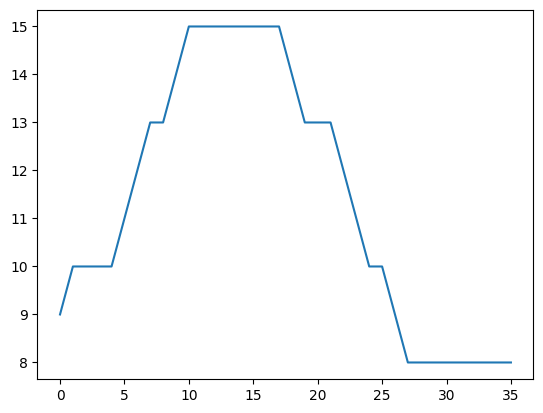

In [4]:
plt.plot(df['Descriptor'][0])

In [21]:
indices_of_highest = df.nlargest(100, 'Count').index
# Determine the maximum length of the lists
max_length = df['Descriptor'].apply(len).max()

# Convert the lists column into a numpy array with padding
X = np.zeros((len(df), max_length), dtype=int)
for i, row in enumerate(df['Descriptor']):
    X[i, :len(row)] = row

In [6]:

def autocorrelation(signal):
    """Compute the autocorrelation function of a signal."""
    n = len(signal)
    mean = np.mean(signal)
    centered_signal = signal - mean
    autocorr = correlate(centered_signal, centered_signal, mode='full') /  n
    return autocorr

A = np.zeros((X.shape[0], X.shape[1]*2-1))
for i in range(X.shape[0]):
    A[i] = autocorrelation(X[i])

#A_embedded = X @ X[indices_of_highest, :].T 
#A_embedded.shape


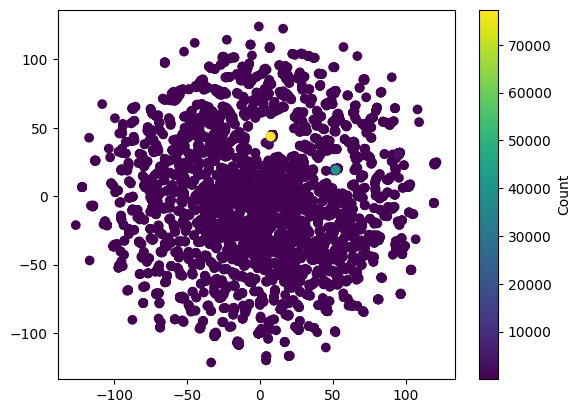

"\n# Perform LLE\nA_embedded = TSNE(n_components=2, learning_rate='auto', init='pca', random_state=42, perplexity=3).fit_transform(A)\nplt.scatter(A_embedded[::-1,0], A_embedded[::-1,1],c=df['Count'][::-1], cmap='viridis')\nplt.colorbar(label='Count')\nplt.show()\n"

In [14]:
from scipy.spatial.distance import cdist

k = 50
# Perform LLE
X_embedded = TSNE(n_components=2, learning_rate='auto', init='random', random_state=42, perplexity=3).fit_transform(X)
plt.scatter(X_embedded[::-1,0], X_embedded[::-1,1],c=df['Count'][::-1], cmap='viridis')
plt.colorbar(label='Count')
plt.show()
'''
# Perform LLE
A_embedded = TSNE(n_components=2, learning_rate='auto', init='pca', random_state=42, perplexity=3).fit_transform(A)
plt.scatter(A_embedded[::-1,0], A_embedded[::-1,1],c=df['Count'][::-1], cmap='viridis')
plt.colorbar(label='Count')
plt.show()
'''

count 77352 Preprocessed_N48 after 13th.csv
count 55 Preprocessed_N48 after 13th.csv
count 64 Preprocessed_N48 after 13th.csv


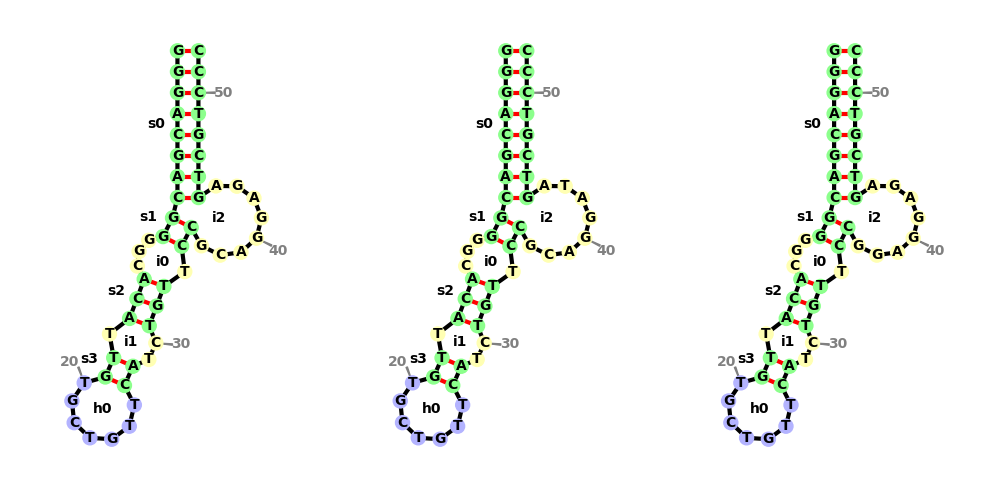

count 622 Preprocessed_N48 after 13th.csv
count 72 Preprocessed_N48 after 13th.csv
count 59 Preprocessed_N48 after 13th.csv


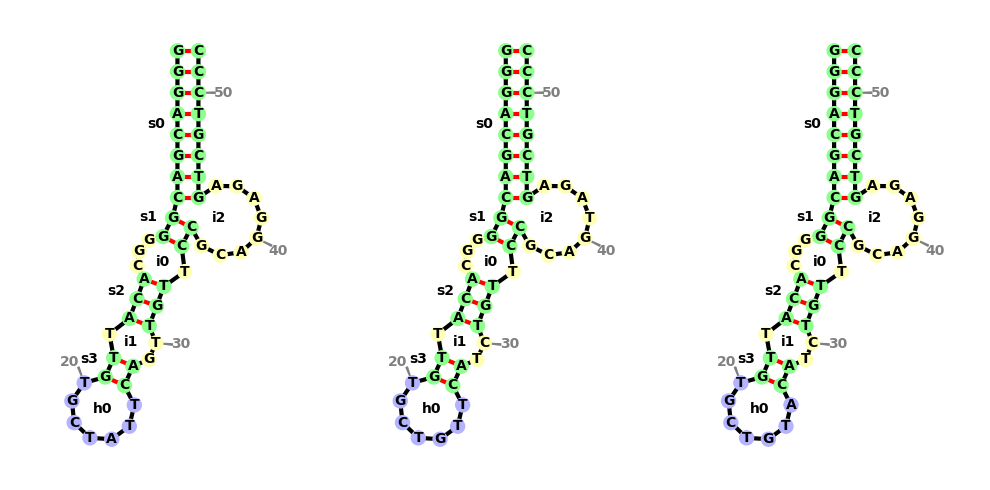

count 92 Preprocessed_N48 after 13th.csv
count 5947 Preprocessed_N48 after 13th.csv
count 68 Preprocessed_N48 after 13th.csv


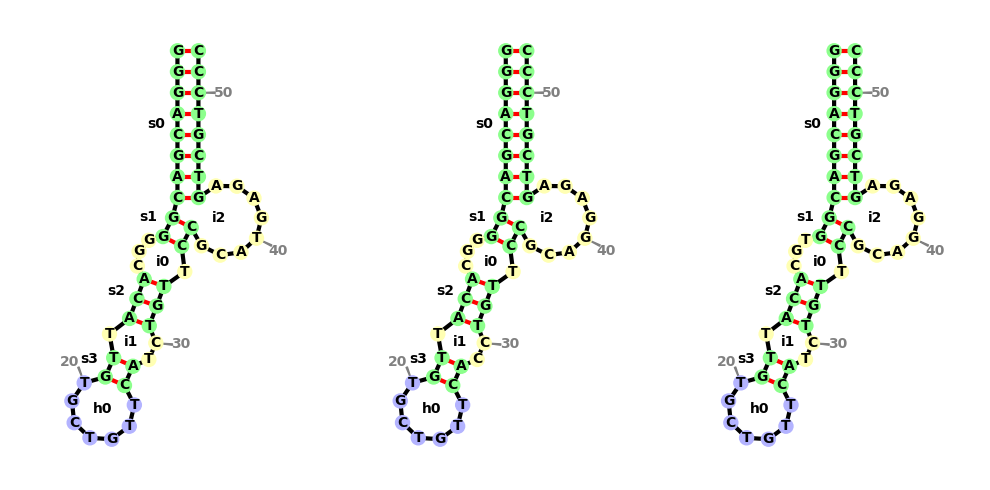

count 63 Preprocessed_N48 after 13th.csv
count 1 Preprocessed_N48 after 13th.csv
count 3 Preprocessed_N58 after 12th.csv


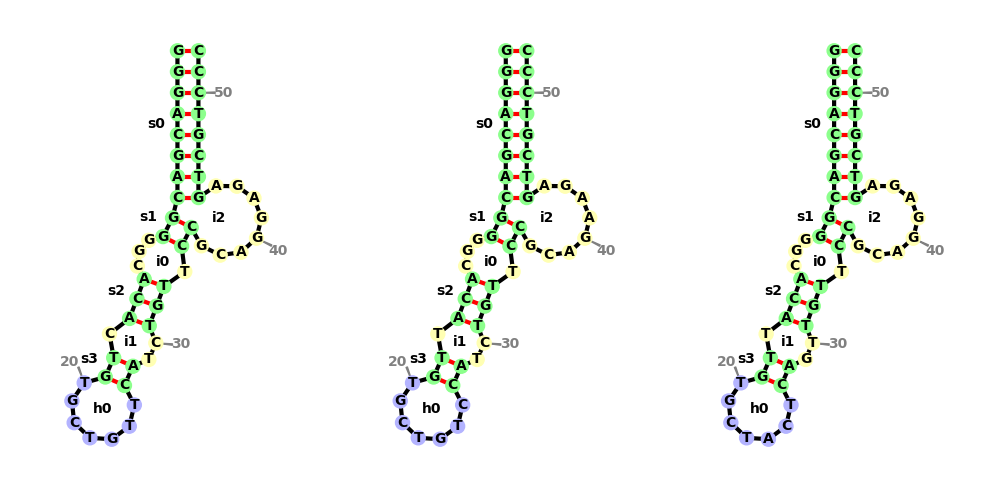

count 5 Preprocessed_N48 after 13th.csv
count 1 Preprocessed_N48 after 13th.csv
count 4 Preprocessed_N48 after 13th.csv


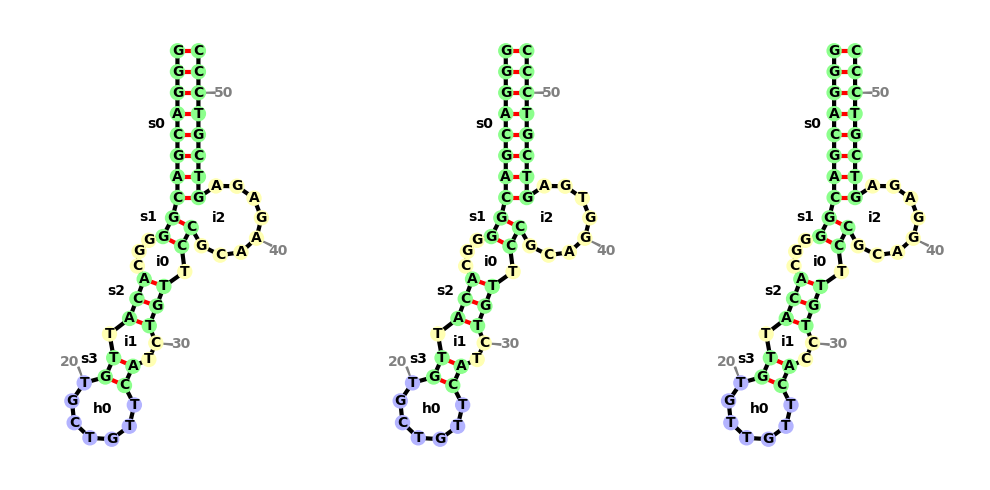

count 1 Preprocessed_N48 after 13th.csv
count 2 Preprocessed_N48 after 9th.csv
count 1 Preprocessed_N48 after 9th.csv


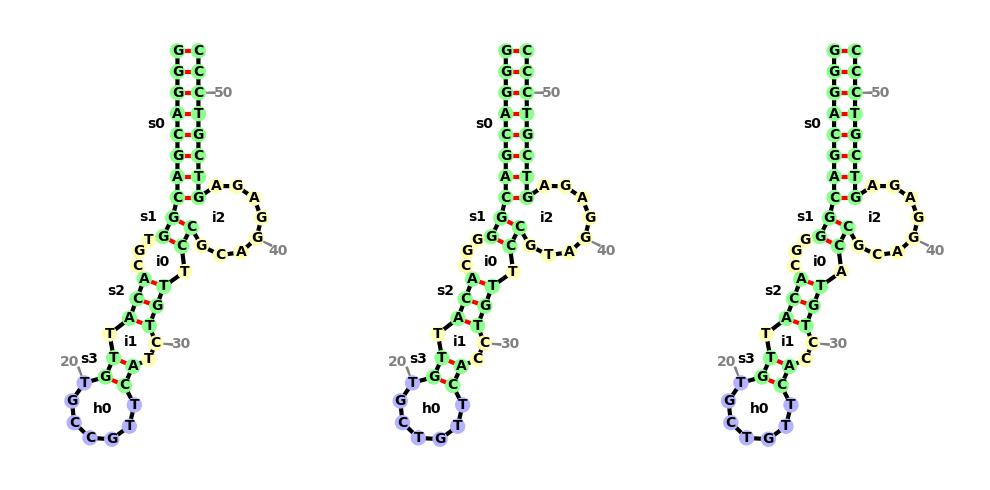

count 2 Preprocessed_N48 after 9th.csv
count 1 Preprocessed_N48 after 9th.csv
count 2 Preprocessed_N58 after 12th.csv


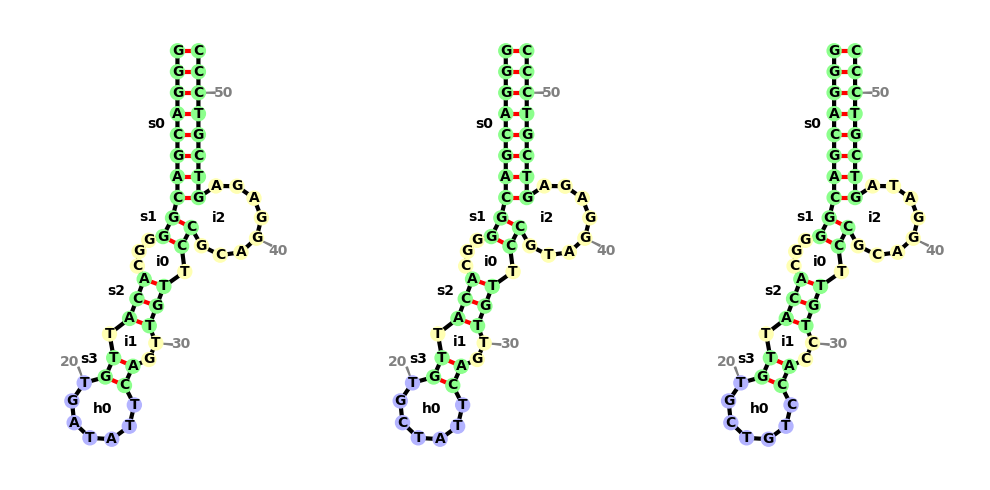

count 1 Preprocessed_N48 after 9th.csv
count 5 Preprocessed_N48 after 13th.csv
count 2 Preprocessed_N58 after 12th.csv


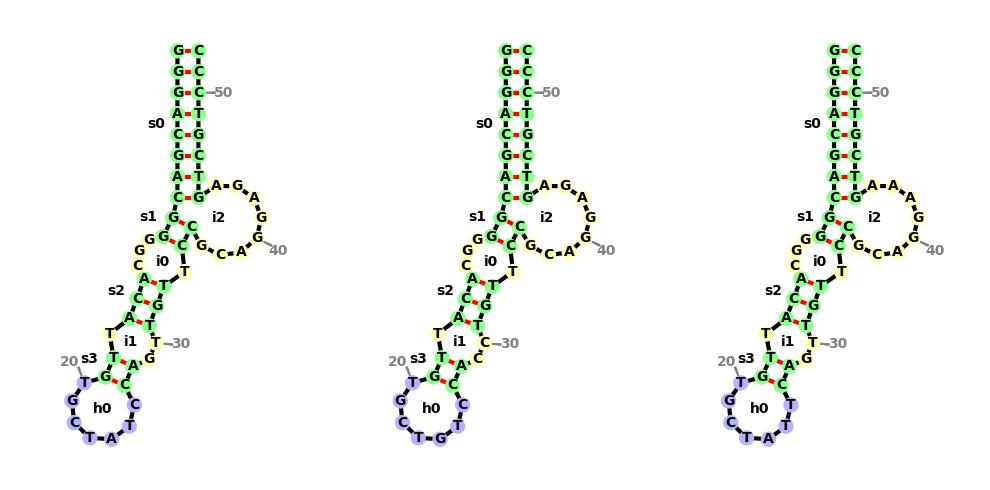

count 1 Preprocessed_N48 after 13th.csv
count 2 Preprocessed_N58 after 12th.csv
count 1 Preprocessed_N48 after 9th.csv


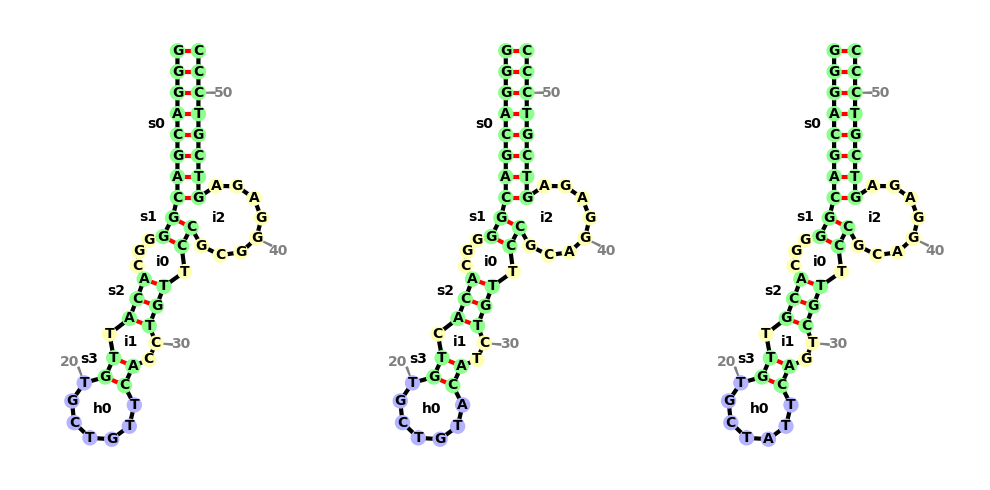

count 1 Preprocessed_N48 after 13th.csv
count 4 Preprocessed_N48 after 13th.csv
count 1 Preprocessed_N48 after 13th.csv


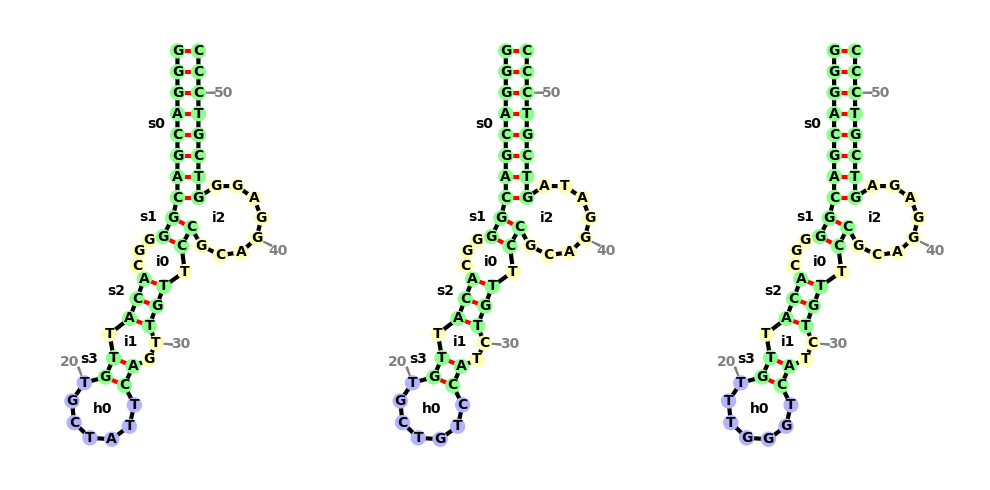

count 1 Preprocessed_N48 after 13th.csv
count 3 Preprocessed_N58 after 12th.csv
count 8 Preprocessed_N58 after 12th.csv


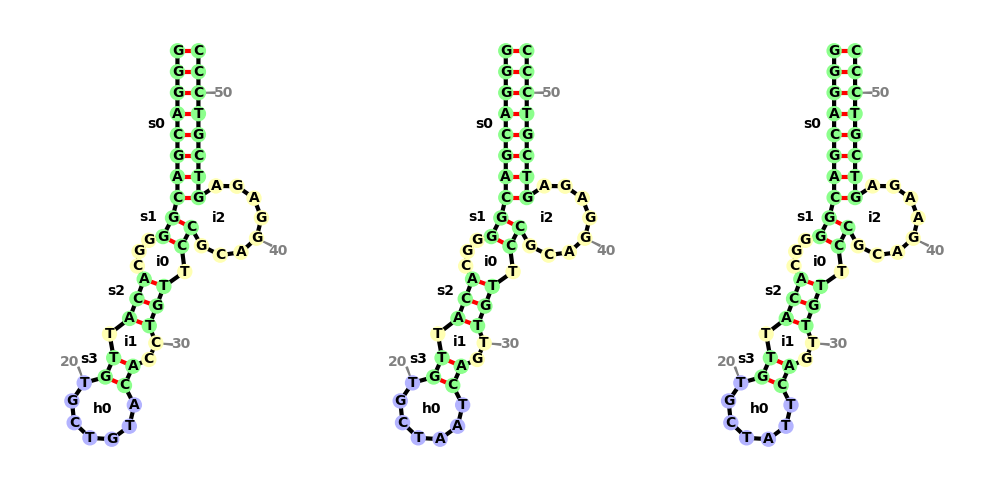

count 4 Preprocessed_N58 after 12th.csv
count 1 Preprocessed_N48 after 9th.csv
count 1 Preprocessed_N48 after 13th.csv


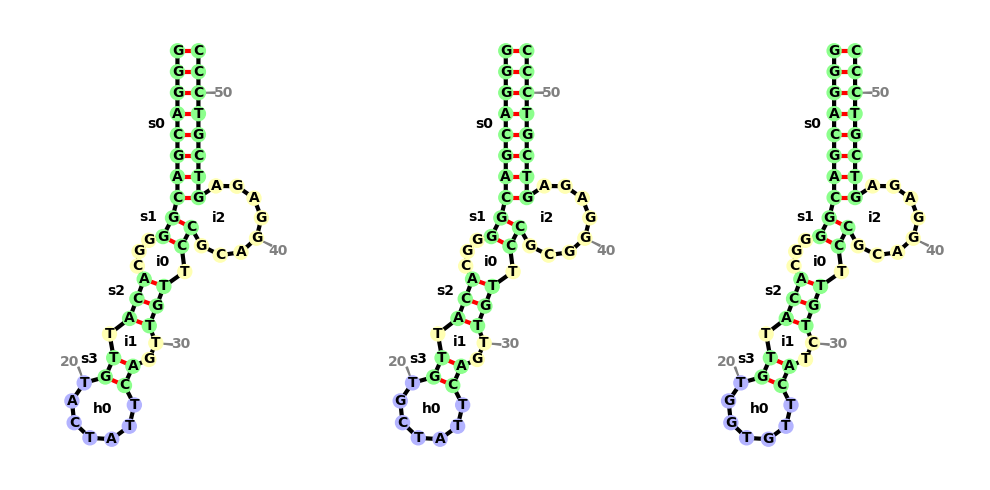

count 6 Preprocessed_N48 after 13th.csv
count 6 Preprocessed_N48 after 13th.csv
count 2 Preprocessed_N48 after 9th.csv


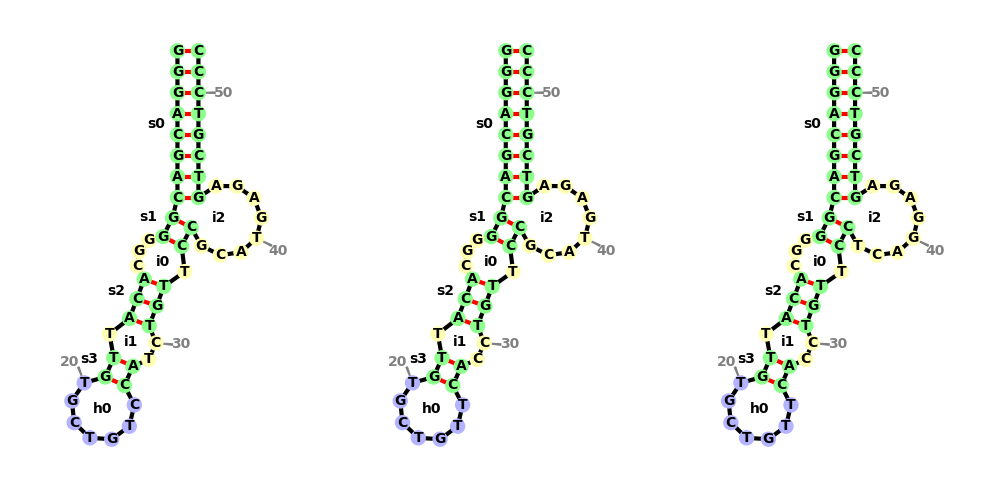

count 1 Preprocessed_N48 after 9th.csv
count 2 Preprocessed_N48 after 13th.csv
count 1 Preprocessed_N48 after 9th.csv


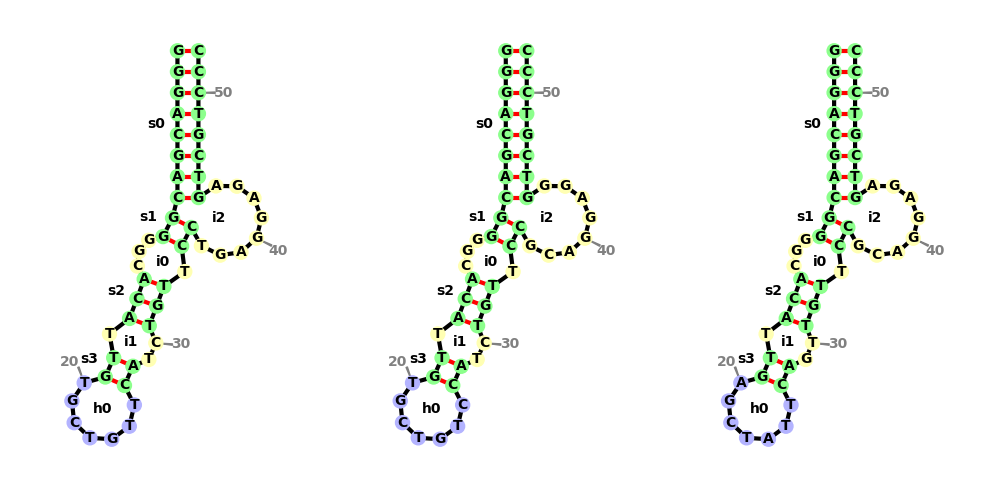

count 1 Preprocessed_N48 after 9th.csv
count 1 Preprocessed_N48 after 9th.csv
count 1 Preprocessed_N48 after 9th.csv


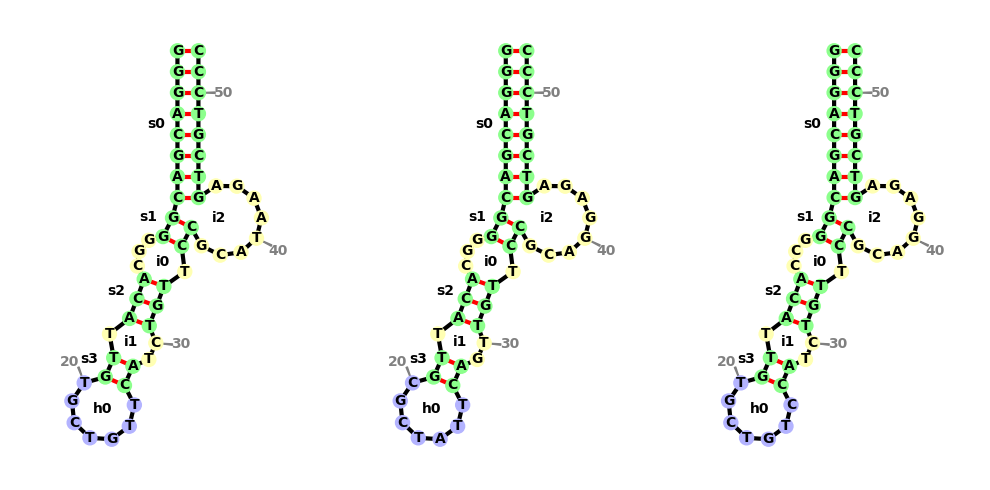

count 1 Preprocessed_N48 after 13th.csv
count 1 Preprocessed_N58 after 12th.csv
count 1 Preprocessed_N48 after 13th.csv


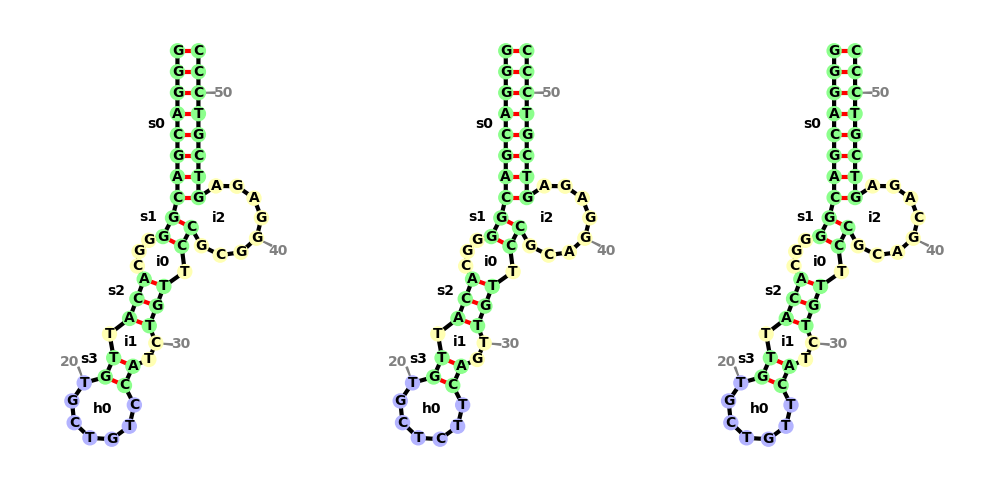

count 6 Preprocessed_N48 after 13th.csv
count 1 Preprocessed_N48 after 13th.csv


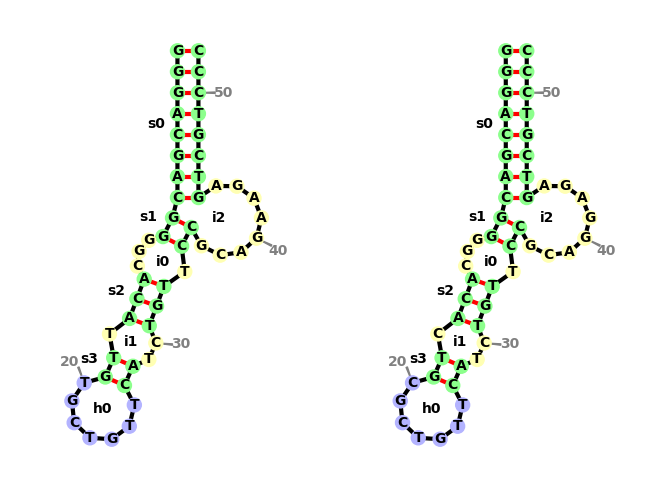

In [71]:
K = 40
distances = cdist(X_embedded[indices_of_highest], X_embedded)
sorted_indices = np.argsort(distances, axis=1)
k_nearest_indices = sorted_indices[0, :k]
df_top_k = df.iloc[k_nearest_indices]
df_top_k= df_top_k.reset_index(drop=False)
# Set the number of plots per row
plots_per_row = 3

# Calculate the number of rows needed
num_rows = (len(df_top_k) + plots_per_row - 1) // plots_per_row

# Iterate over each row
for row in range(num_rows):
    # Create a new figure for the row
    plt.figure(figsize=(10, 5))
    
    # Iterate over plots in the row
    for j in range(plots_per_row):
        # Calculate the index in the DataFrame
        index = row * plots_per_row + j
        
        # Check if the index is within the DataFrame length
        if index < len(df_top_k):
            # Print the count
            print('count', df_top_k['Count'][index], df_top_k['File'][index])
            
            # Create a subplot for each plot
            plt.subplot(1, plots_per_row, j + 1)
            
            # Create a BulgeGraph from dot-bracket notation and sequence
            bg = BulgeGraph.from_dotbracket(df_top_k['Structure_graph_match'][index], df_top_k['Sequence'][index])
            
            # Plot the RNA structure
            fvm.plot_rna(bg, text_kwargs={"fontweight": "black"}, lighten=0.7, backbone_kwargs={"linewidth": 3})
    
    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()


count 38755 Preprocessed_N48 after 13th.csv
count 49 Preprocessed_N48 after 13th.csv
count 29 Preprocessed_N48 after 13th.csv


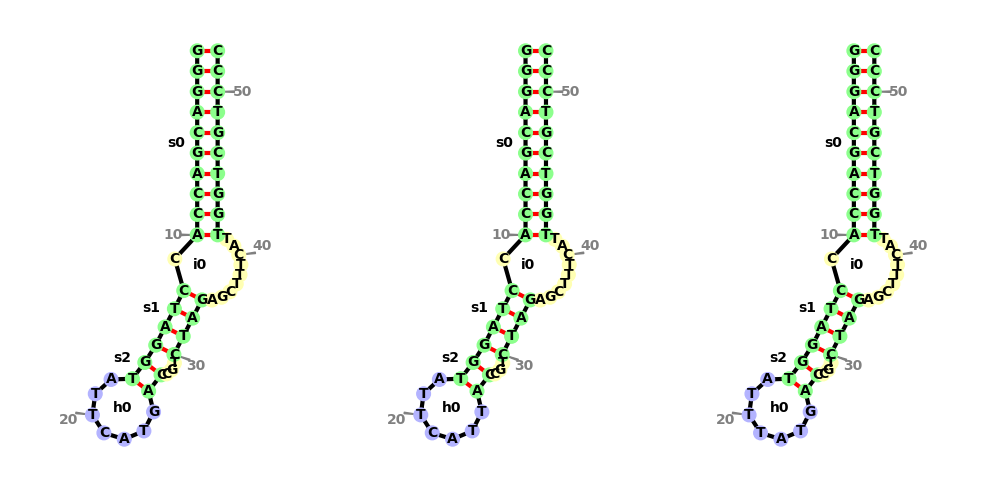

count 16 Preprocessed_N48 after 13th.csv
count 20 Preprocessed_N48 after 13th.csv
count 103 Preprocessed_N48 after 13th.csv


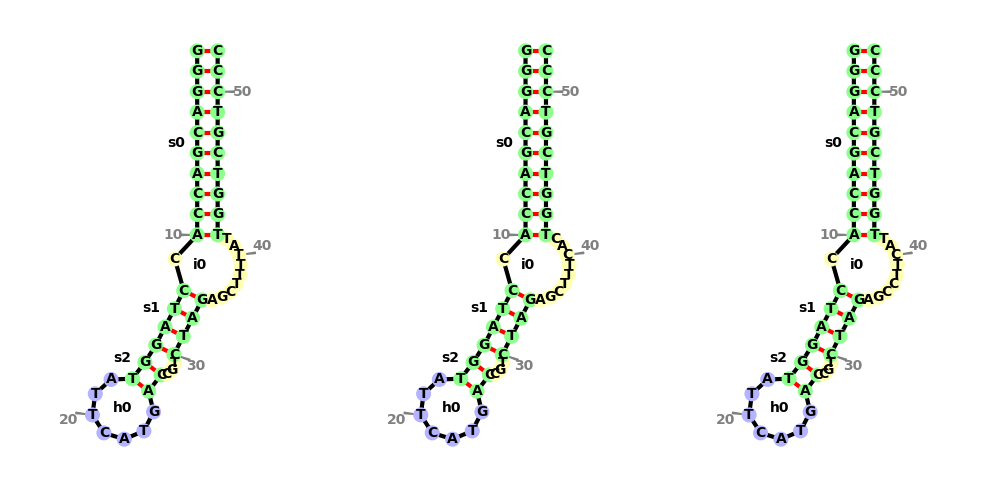

count 33 Preprocessed_N48 after 13th.csv
count 38 Preprocessed_N48 after 13th.csv
count 9 Preprocessed_N48 after 13th.csv


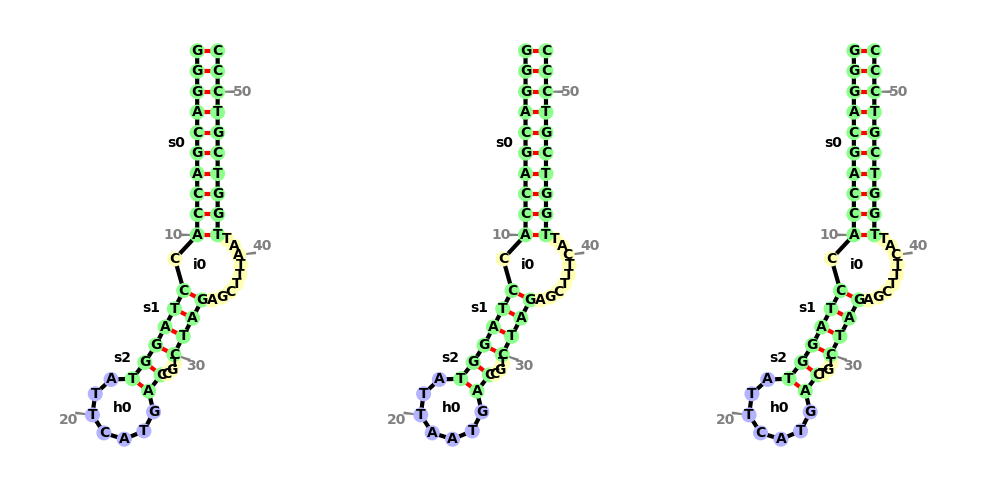

count 9 Preprocessed_N48 after 13th.csv
count 69 Preprocessed_N48 after 13th.csv
count 6 Preprocessed_N48 after 13th.csv


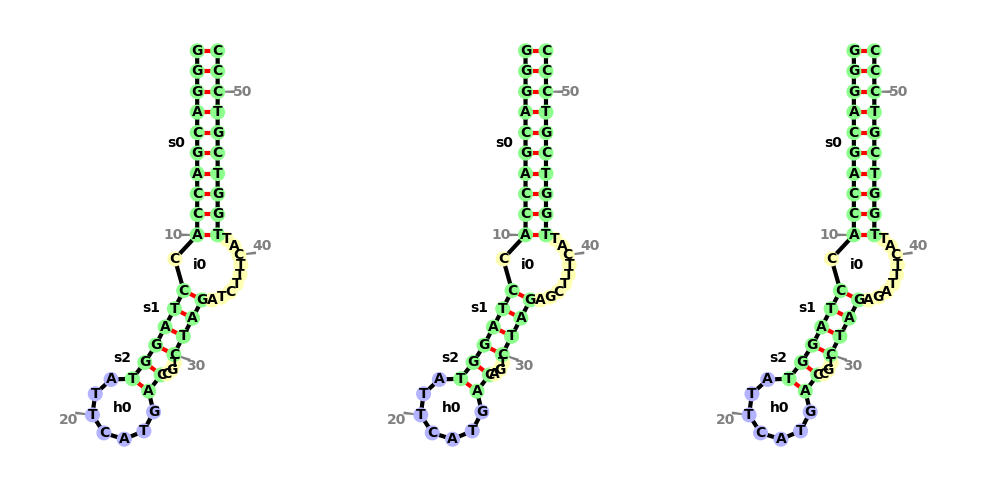

count 1 Preprocessed_N58 after 12th.csv
count 6 Preprocessed_N48 after 13th.csv
count 1 Preprocessed_N48 after 13th.csv


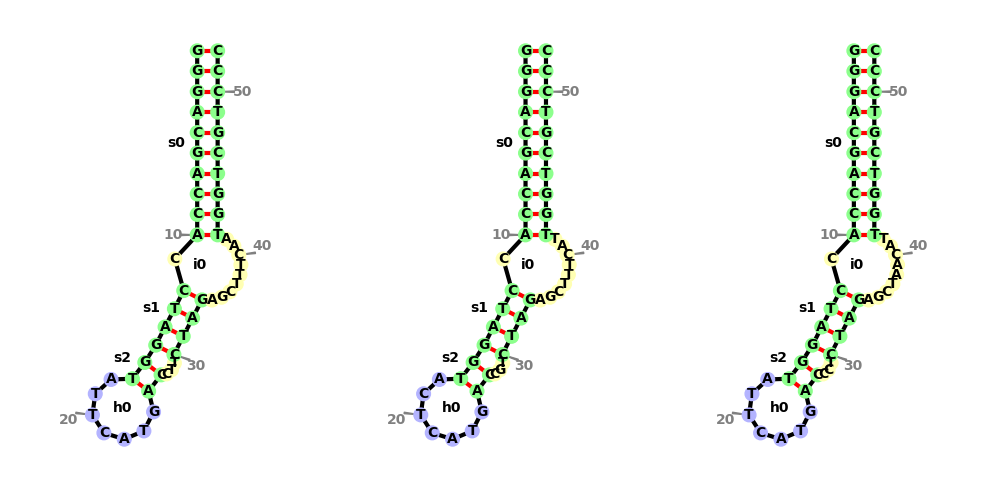

count 7 Preprocessed_N48 after 13th.csv
count 1 Preprocessed_N58 after 16th.csv
count 1 Preprocessed_N58 after 12th.csv


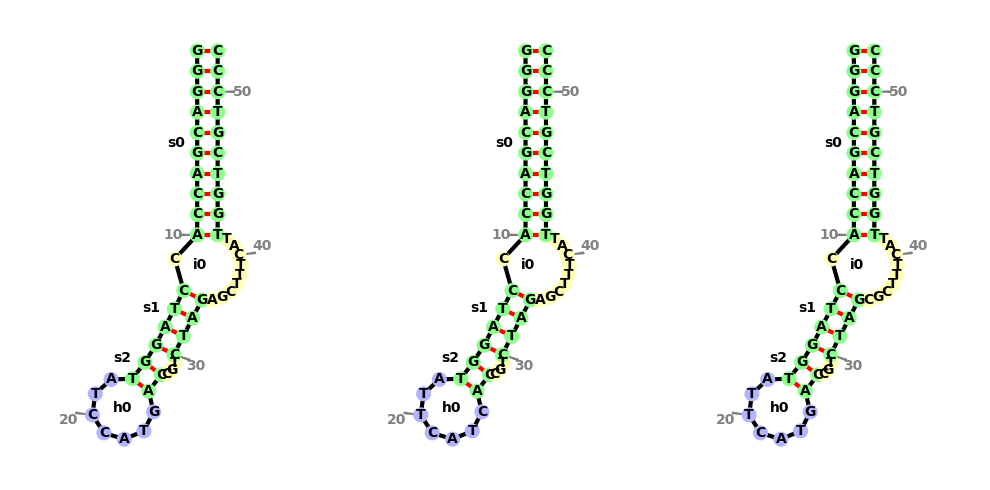

count 1 Preprocessed_N58 after 12th.csv
count 1 Preprocessed_N48 after 13th.csv
count 1 Preprocessed_N58 after 16th.csv


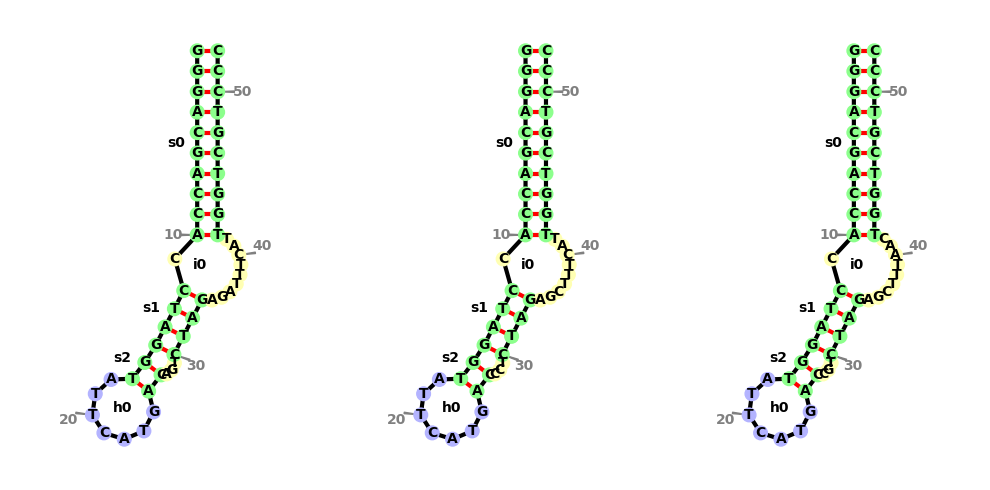

count 1 Preprocessed_N48 after 13th.csv
count 1 Preprocessed_N58 after 12th.csv
count 1 Preprocessed_N58 after 16th.csv


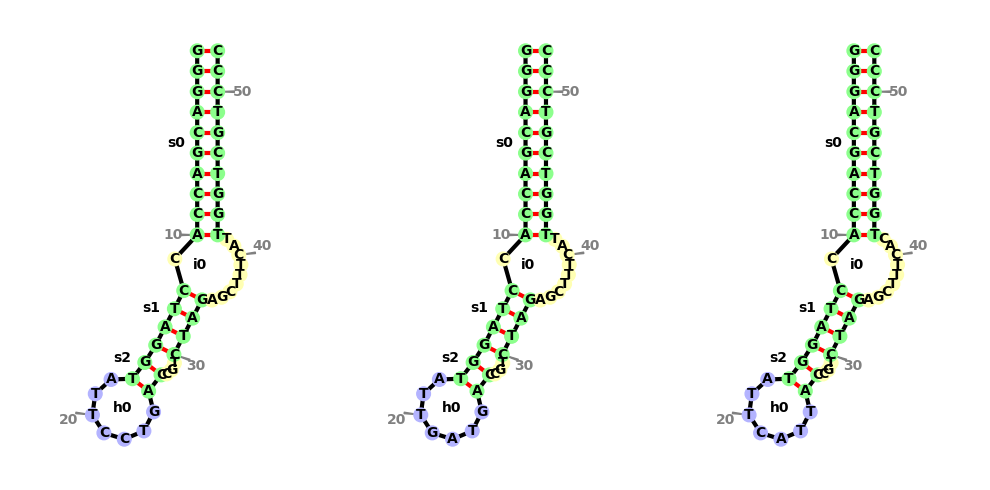

count 6 Preprocessed_N48 after 13th.csv
count 2 Preprocessed_N48 after 13th.csv
count 1 Preprocessed_N48 after 13th.csv


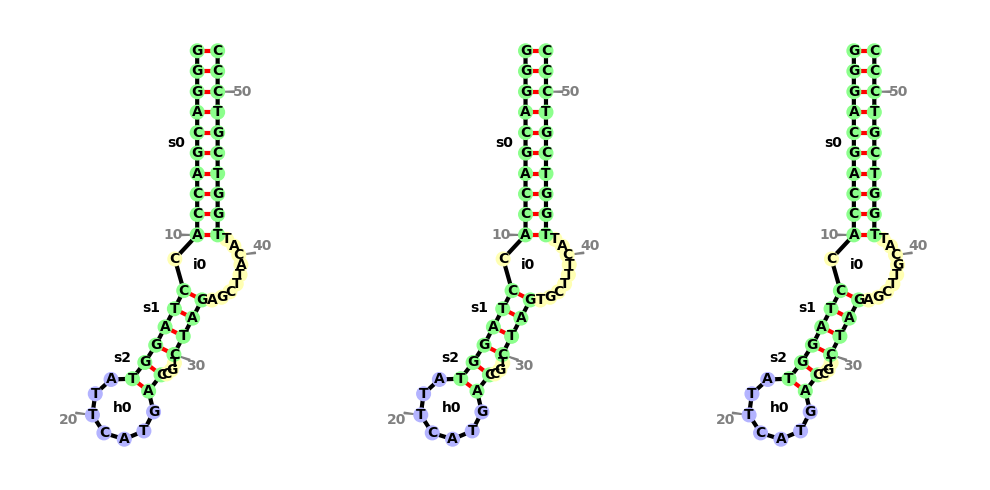

count 3 Preprocessed_N48 after 13th.csv
count 1 Preprocessed_N48 after 9th.csv
count 3 Preprocessed_N48 after 13th.csv


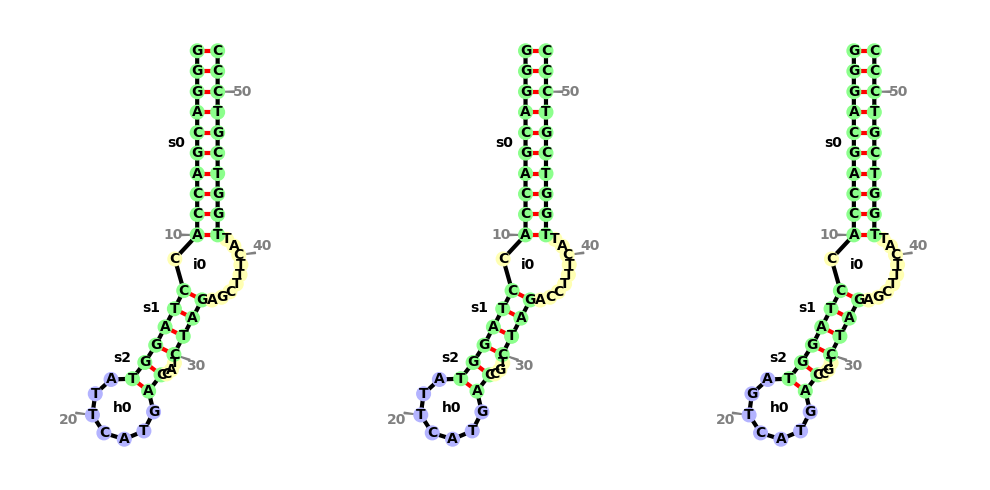

count 1 Preprocessed_N48 after 9th.csv
count 3 Preprocessed_N48 after 13th.csv
count 1 Preprocessed_N58 after 16th.csv


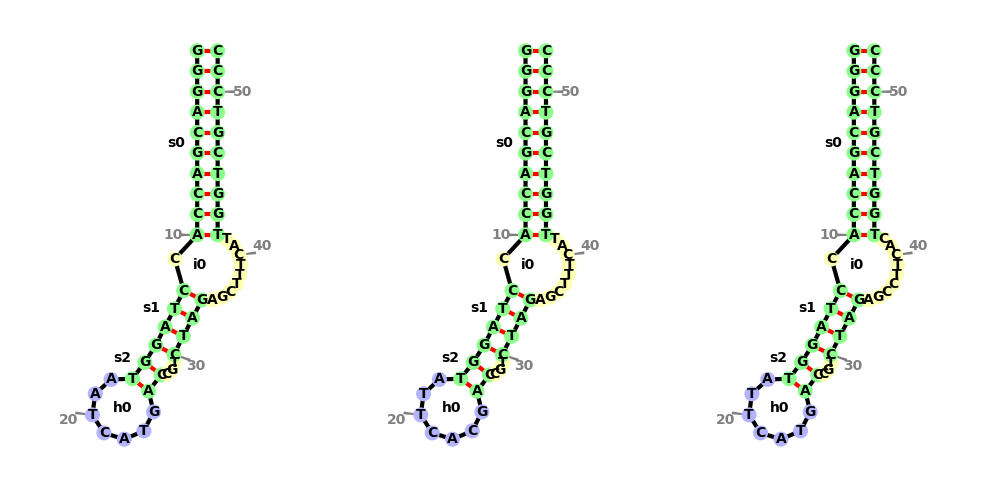

count 3 Preprocessed_N48 after 13th.csv
count 4 Preprocessed_N48 after 13th.csv
count 4 Preprocessed_N48 after 13th.csv


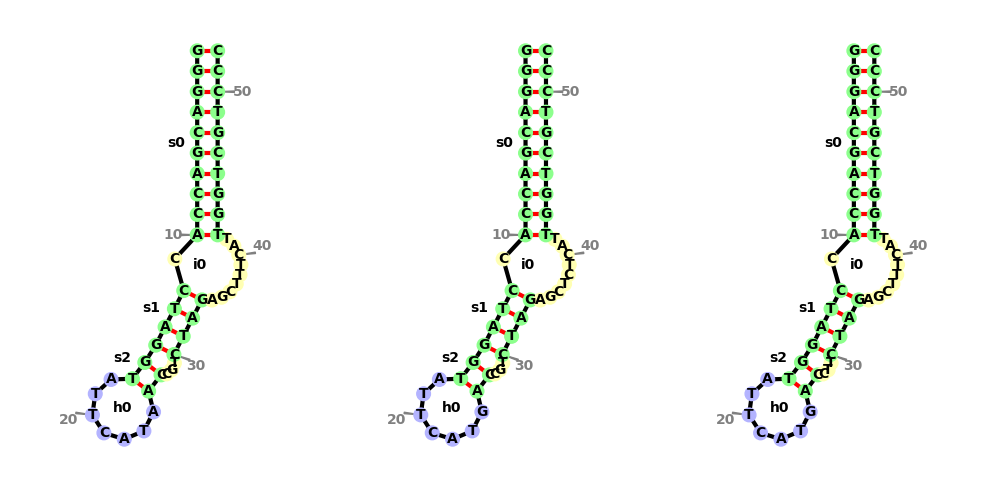

count 1 Preprocessed_N48 after 13th.csv
count 4 Preprocessed_N48 after 13th.csv
count 1 Preprocessed_N58 after 16th.csv


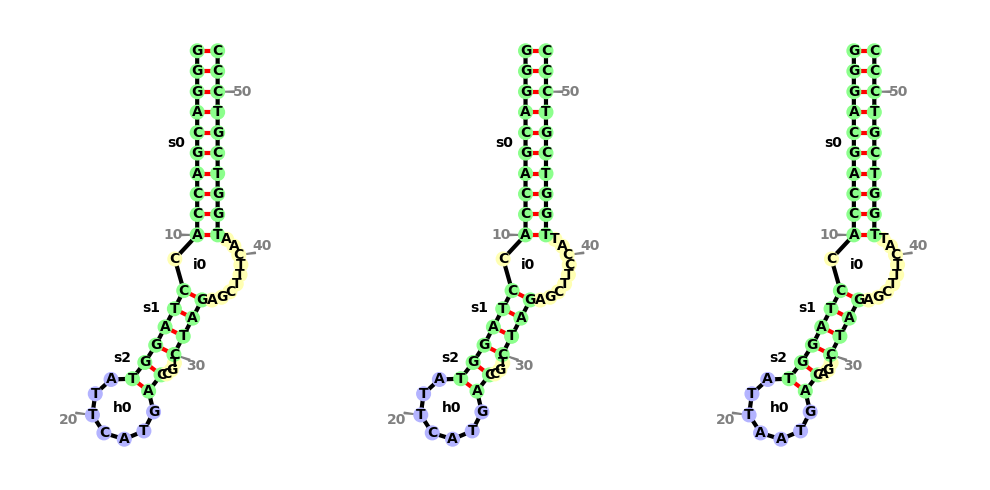

count 1 Preprocessed_N48 after 13th.csv
count 4 Preprocessed_N58 after 12th.csv
count 3 Preprocessed_N58 after 12th.csv


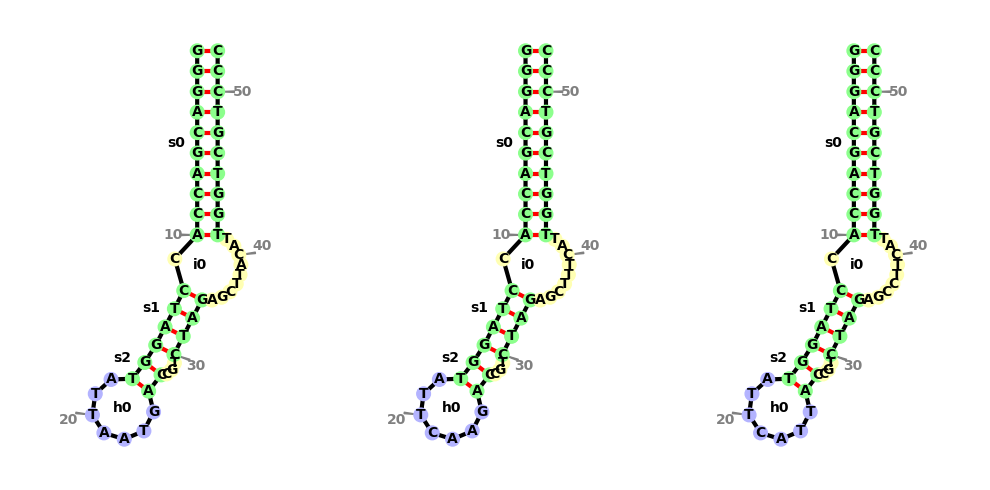

count 2 Preprocessed_N58 after 12th.csv
count 2 Preprocessed_N48 after 13th.csv
count 5 Preprocessed_N48 after 13th.csv


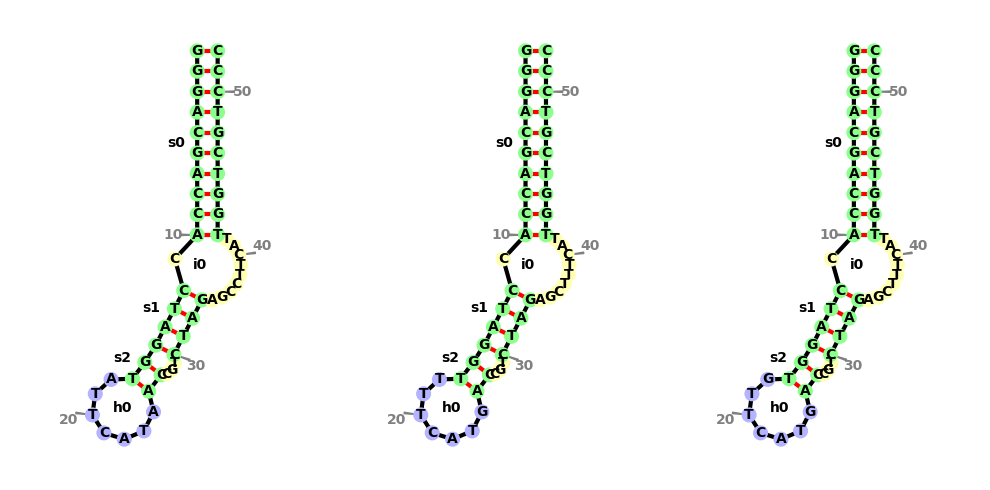

count 1 Preprocessed_N58 after 16th.csv
count 1 Preprocessed_N48 after 13th.csv
count 1 Preprocessed_N48 after 13th.csv


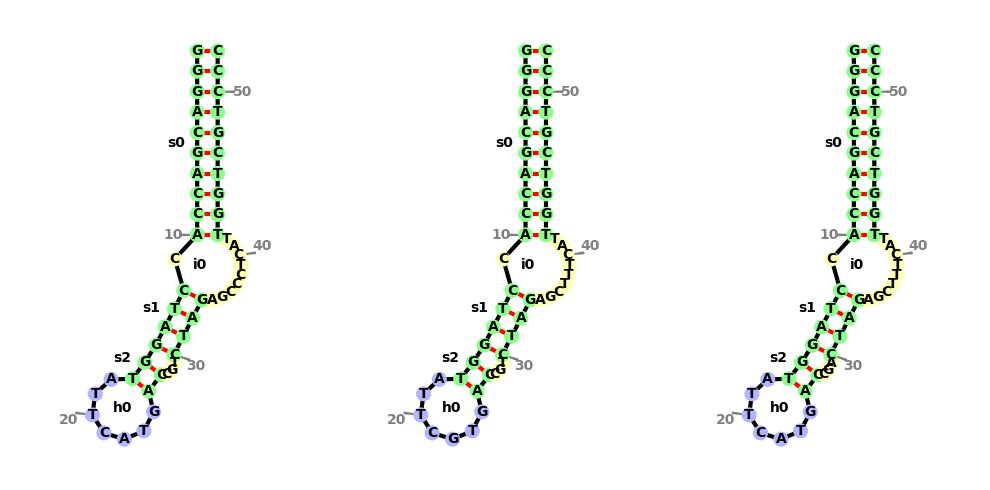

count 1 Preprocessed_N58 after 12th.csv
count 1 Preprocessed_N58 after 12th.csv


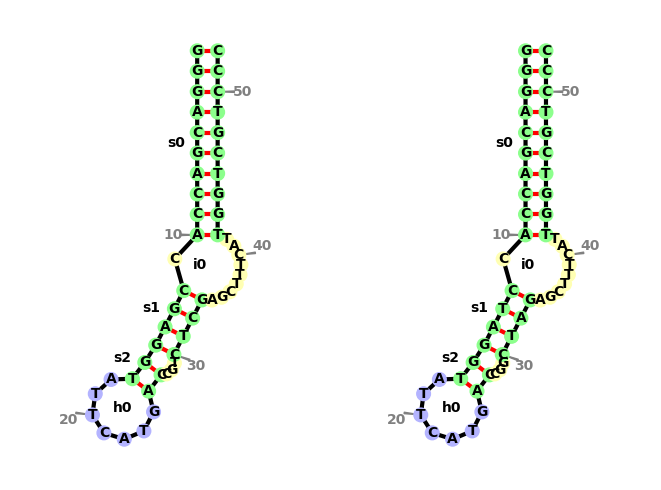

In [74]:
K = 40
distances = cdist(X_embedded[indices_of_highest], X_embedded)
sorted_indices = np.argsort(distances, axis=1)
k_nearest_indices = sorted_indices[1, :k]
df_top_k = df.iloc[k_nearest_indices]
df_top_k= df_top_k.reset_index(drop=False)
# Set the number of plots per row
plots_per_row = 3

# Calculate the number of rows needed
num_rows = (len(df_top_k) + plots_per_row - 1) // plots_per_row

# Iterate over each row
for row in range(num_rows):
    # Create a new figure for the row
    plt.figure(figsize=(10, 5))
    
    # Iterate over plots in the row
    for j in range(plots_per_row):
        # Calculate the index in the DataFrame
        index = row * plots_per_row + j
        
        # Check if the index is within the DataFrame length
        if index < len(df_top_k):
            # Print the count
            print('count', df_top_k['Count'][index], df_top_k['File'][index])
            
            # Create a subplot for each plot
            plt.subplot(1, plots_per_row, j + 1)
            
            # Create a BulgeGraph from dot-bracket notation and sequence
            bg = BulgeGraph.from_dotbracket(df_top_k['Structure_graph_match'][index], df_top_k['Sequence'][index])
            
            # Plot the RNA structure
            fvm.plot_rna(bg, text_kwargs={"fontweight": "black"}, lighten=0.7, backbone_kwargs={"linewidth": 3})
    
    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()